In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [429]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import pandas as pd
import pathlib
from utils import *

# Process results

In [3]:
data_path = pathlib.Path('/home/users/bjornmik/datasets/sweep_10/')

In [259]:
errors = compute_errors(data_path)#, sample=100, force_sample=True)

  0%|          | 0/5 [00:00<?, ?it/s]

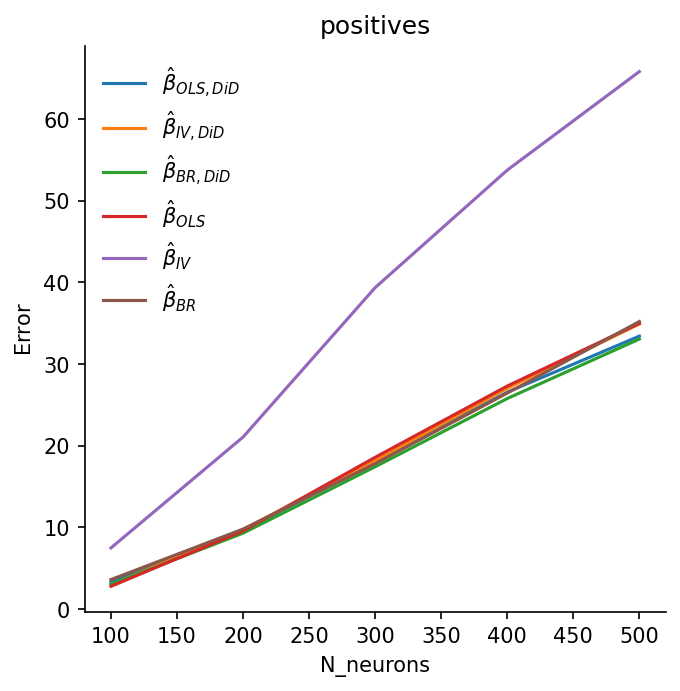

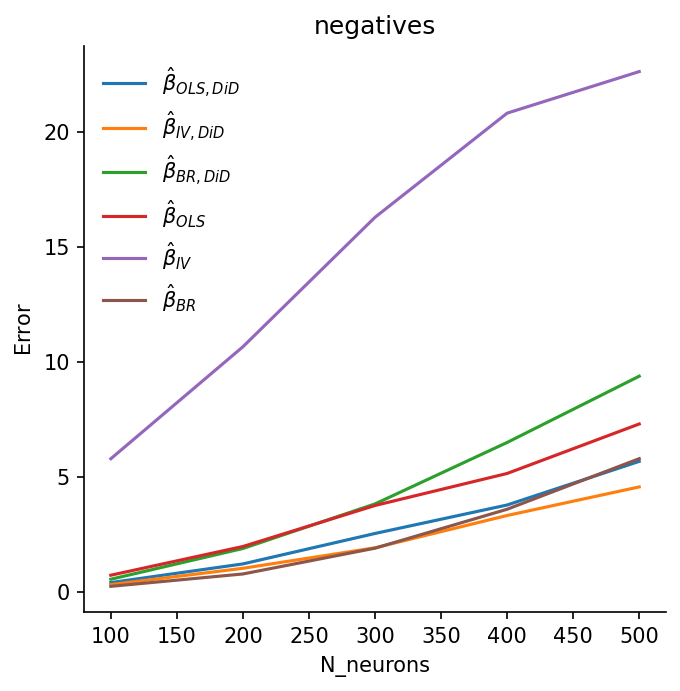

In [260]:
plot_errors(errors, 'n_neurons')

In [4]:
error_trials = compute_error_trials(data_path, n_samples=100)

  0%|          | 0/500 [00:00<?, ?it/s]

In [6]:
errors = compute_error_confidence(errors, error_trials)

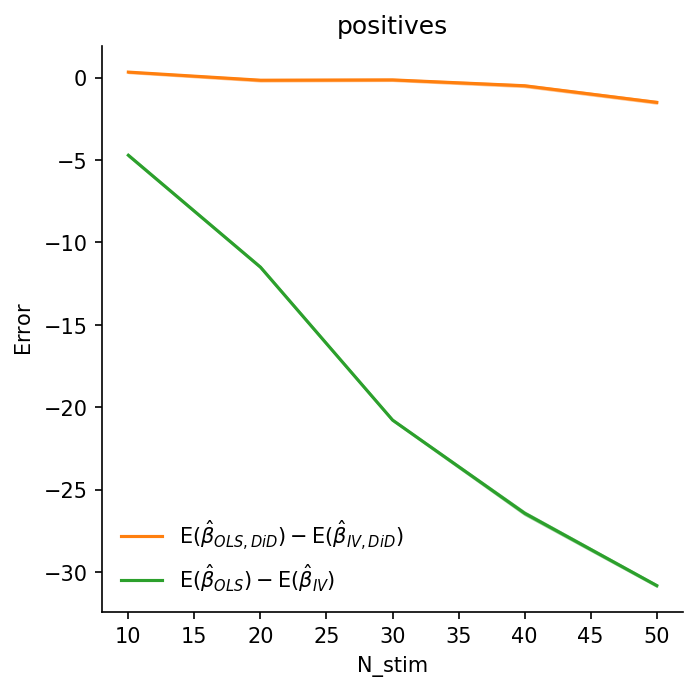

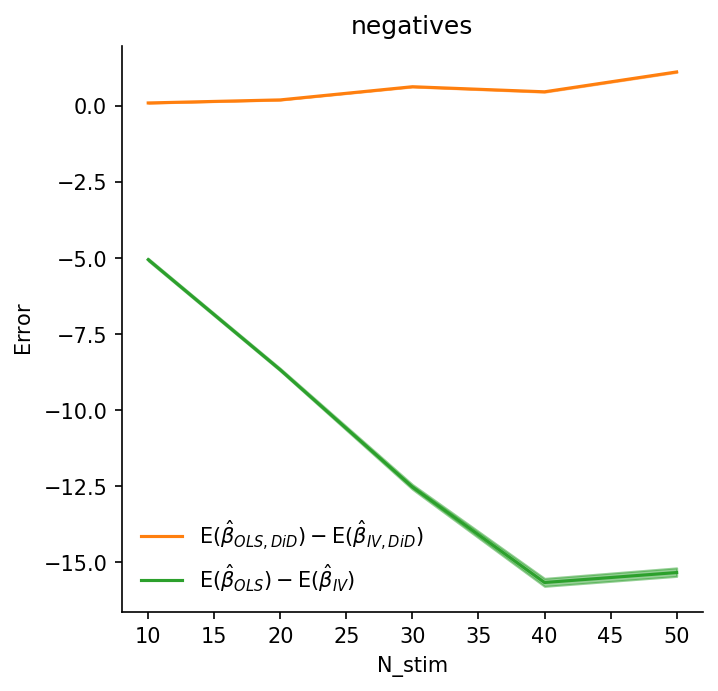

In [8]:
plot_error_difference(errors, 'n_stim')

# Convergence

In [9]:
error_convergence = compute_error_convergence(data_path)

  0%|          | 0/800 [00:00<?, ?it/s]

In [10]:
error_convergence_trials = compute_error_convergence_trials(data_path, n_samples=100)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [11]:
samples = compute_all_samples(data_path)

  0%|          | 0/5 [00:00<?, ?it/s]

In [359]:
index = int(errors['positives'].query('n_neurons==500').index.values)
index

4

In [360]:
errors['positives'].loc[index]

path                   /home/users/bjornmik/datasets/sweep_10/realist...
const                                                                5.0
n_neurons                                                          500.0
n_neurons_ex                                                       400.0
n_neurons_in                                                       100.0
dt                                                                 0.001
ref_scale                                                           10.0
abs_ref_scale                                                        3.0
spike_scale                                                          5.0
abs_ref_strength                                                  -100.0
rel_ref_strength                                                   -30.0
stim_scale                                                           2.0
stim_strength                                                        7.0
stim_period                                        

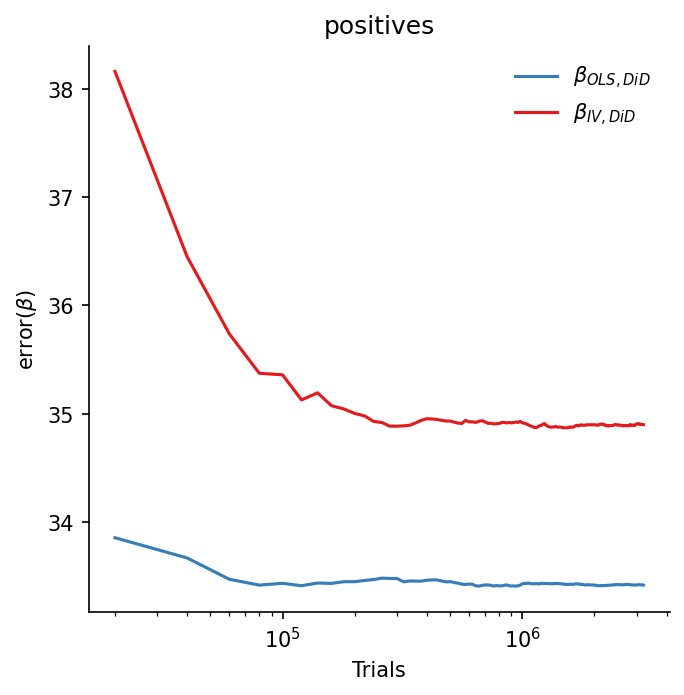

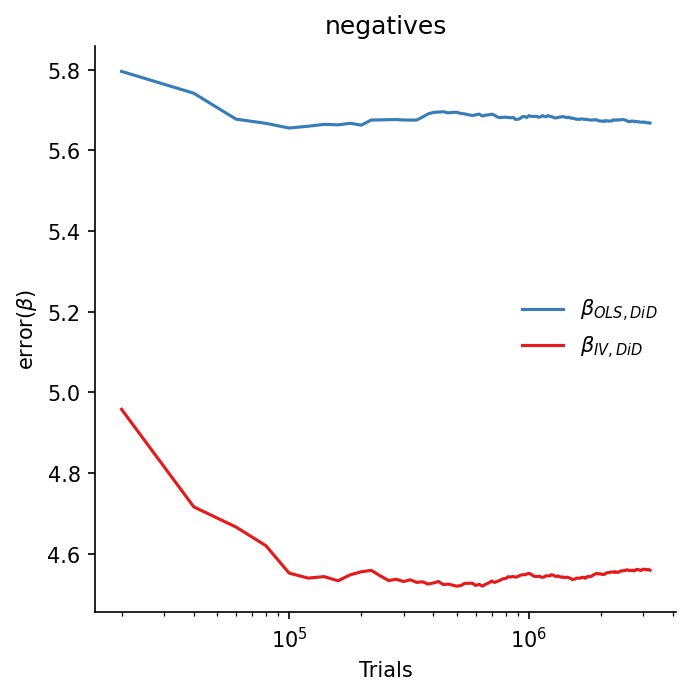

In [361]:
plot_error_convergence(error_convergence, index, ['error_beta_ols_did', 'error_beta_iv_did'])

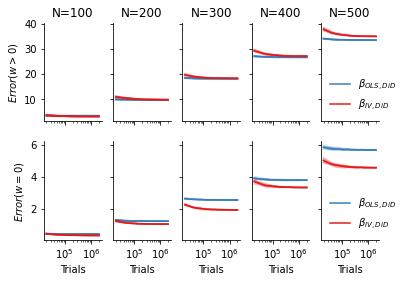

In [362]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey='row')
for i, (n_neurons, df) in enumerate(errors['positives'].groupby('n_neurons')):
    index = int(df.index.values)
    plot_error_convergence_trials( 
        error_convergence_trials, 
        index, 
        keys=['error_beta_ols_did','error_beta_iv_did'], 
        axs=axs.T[i], legend=i==4, xlabels=(False,True), ylabels=[i==0]*2)
    axs[0,i].set_title(f'N={n_neurons:.0f}')

# Regression

In [363]:
df = samples[index]

<AxesSubplot:>

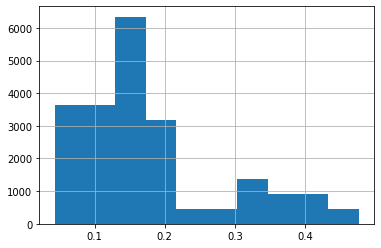

In [364]:
df.hit_rate.hist()

In [365]:
df['ww'] = df.hit_rate.round(3)

In [366]:
subsample = df.groupby('ww').sample(df.groupby('ww').count().source.min())

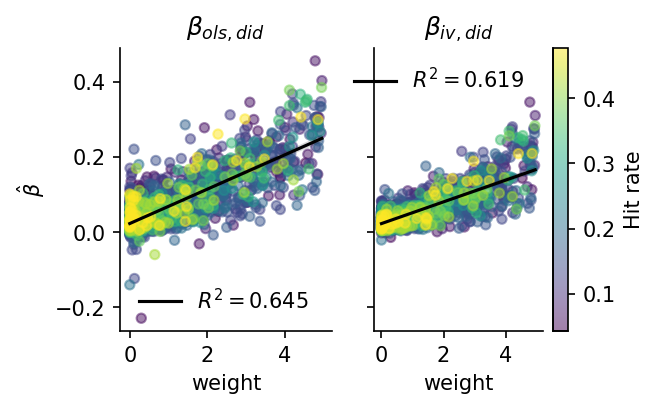

In [367]:
plot_regression(subsample.query('weight>0'), ['beta_ols_did','beta_iv_did'], scatter_kws=dict(s=20, alpha=.5), clabel='Hit rate')

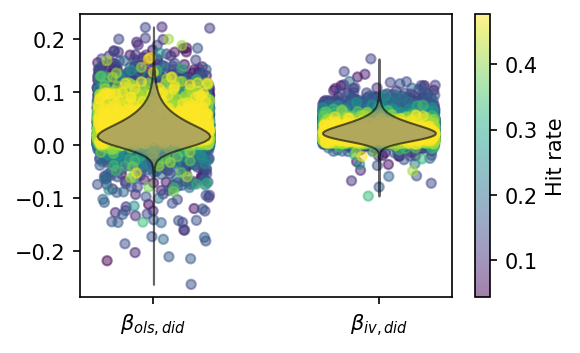

In [368]:
plot_false_positives(subsample.query('weight==0'), ['beta_ols_did', 'beta_iv_did'], scatter_kws=dict(s=20, alpha=.5), clabel='Hit rate')

# Classify

In [430]:
keys = ['beta_ols_did', 'beta_iv_did', 'beta_brew_did']

In [432]:
auroc = []
for index, df in samples.items():
#     df = rectify_keys(df, keys)
    ser = df.iloc[0]
    for key in keys:
        a = roc_auc_score(df, key)
        score = {
            'n_neurons': ser.n_neurons,
            'group': key,
            'auroc': a
        }
        auroc.append(score)
auroc = pd.DataFrame(auroc)

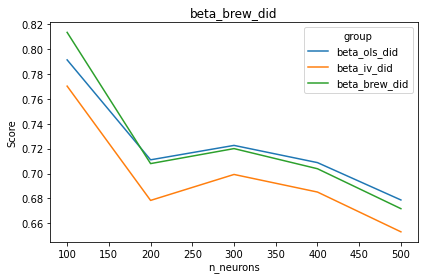

In [433]:
fig, ax = plt.subplots(1,1)
sns.lineplot(
    data=auroc,#.sort_values('n_neurons'),
    x="n_neurons", y='auroc',
    hue="group",
    ax=ax
)
ax.set_ylabel('Score')
ax.set_title(key)
plt.tight_layout()